* 아래 함수는 `weather_localcenter_metadata`와 `weather_5minute_ASOS_2020-2023.parquet`, `holiday.csv`를 사용하여 5분 단위 기상대표값을 도출합니다.
* 본 모델링에서는 기상인자로 최고기온, 최저기온, 평균일사량 데이터를 사용하고자 합니다. 일사량의 결측치 비율을 최소화 하기 위해 울산시를 제외한 특별시 및 광역시 데이터를 사용하였으며 (울산시 일사량 데이터의 대부분이 결측치였음), 강원도의 기상 인자도 반영하기 위해 도내에서 가장 인구가 많은 도시인 원주를 포함하였습니다.
* 보간법을 적용하기 전의 기온과 일사량의 결측치 비율은 전체 대비 0.2%, 0.4% 수준이며, 선형보간법을 통해 결측치를 보완하고자 했습니다.

In [2]:
def weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 특성 반영
  # 휴일이 아니면 0, 휴일이면 1

  holiday = pd.read_csv(holiday_path)

  for row_number in range(representative_weather.shape[0]):
    if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
      representative_weather.at[row_number, 'holiday'] = 1
    else:
      representative_weather.at[row_number, 'holiday'] = 0

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  return representative_weather

In [3]:
# 기상대표값 데이터 생성하기

weather_metadata_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/ASOS (2020-2023)/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/time/holidays.csv'
representative_weather = weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path)

전력 데이터는 지호님이 완성해주신 `power_demand_interpolated`를 사용하였습니다.

In [4]:
# 전력 데이터 불러오기

import pandas as pd

power = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_interpolated.csv')
power.columns = ['datetime', 'load']

기상인자 대표값과 보간 처리된 전력데이터를 일시를 기준으로 Inner Join합니다.

In [5]:
# 전력 데이터와 기상인자 데이터 합치기

target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')

In [124]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338399 entries, 0 to 338398
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   datetime         338399 non-null  object 
 1   max_temp         338399 non-null  float64
 2   min_temp         338399 non-null  float64
 3   mean_insolation  338399 non-null  float64
 4   weekday_0        338399 non-null  uint8  
 5   weekday_1        338399 non-null  uint8  
 6   weekday_2        338399 non-null  uint8  
 7   weekday_3        338399 non-null  uint8  
 8   holiday          338399 non-null  float64
 9   month_1          338399 non-null  uint8  
 10  month_2          338399 non-null  uint8  
 11  month_3          338399 non-null  uint8  
 12  month_4          338399 non-null  uint8  
 13  month_5          338399 non-null  uint8  
 14  month_6          338399 non-null  uint8  
 15  month_7          338399 non-null  uint8  
 16  month_8          338399 non-null  uint

데이터가 너무 많아 한칸씩 내려오는 방식이 아닌 사전에 stride 변수의 크기만큼 내려오도록 했으며, RAM 사용량은 약 50G 가량입니다.

In [11]:
# 학습 및 테스트 데이터 생성

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# MinMaxScaling (Binary 변수는 제외)

ss_1 = MinMaxScaler()
ss_2 = MinMaxScaler()
dataset_1 = pd.DataFrame(ss_1.fit_transform(target_df.iloc[:,1:4]))
dataset_2 = target_df.iloc[:,4:-1]
dataset_3 = pd.DataFrame(ss_2.fit_transform(np.array(target_df['load']).reshape(-1, 1)))
dataset = pd.concat([dataset_1, dataset_2, dataset_3], axis = 1)

# Train, Test dataset 만들기

sequence_length = 2016
step_length = 72
num_of_columns = 45
stride = 5

# 마지막 (sequence_length + step_length)개의 행을 test dataset으로,
# 나머지를 train dataset으로 설정 

train_dataset = dataset.iloc[:-1*(sequence_length + step_length), :]
test_dataset = dataset.iloc[-1*(sequence_length + step_length):, :]

# train data가 들어갈 빈 array와 array의 크기 설정
# list를 array로 변환하는 것보다 빈 array에 값을 채워넣는 것이 메모리 사용량이 적었습니다.

data_size = (train_dataset.shape[0] - step_length - sequence_length) // stride
X_train, y_train = np.zeros((data_size, sequence_length, num_of_columns)), np.zeros((data_size, step_length))

for i in tqdm(range(data_size)):
  idx_start = i * stride # 5칸씩 내려오기
  idx_in = idx_start + sequence_length # sequece_length = 2016 (12 sample in 1hour * 168hour(=7days))
  idx_out = idx_in + step_length # step_length = 72 (12 sample in 1hour * 6hour)
  if idx_out > len(dataset):
    break
  seq_x = np.array(train_dataset.iloc[idx_start:idx_in, :])
  seq_y = np.array(train_dataset.iloc[idx_in:idx_out, -1])
  X_train[i] = seq_x.reshape((-1, sequence_length, num_of_columns))
  y_train[i] = seq_y.reshape((-1, step_length))

# train data와 같이 X_test, y_test 배열 생성

X_test = np.array(test_dataset.iloc[:-1*step_length, :])
y_test = np.array(test_dataset.iloc[-1*step_length:, -1])

100%|██████████| 66844/66844 [01:06<00:00, 1010.85it/s]


In [12]:
# 학습 및 테스트 데이터 Tensor로 변환한 뒤 Dataloader 만들기

import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.FloatTensor(X_train).cuda()
y_train_tensor = torch.FloatTensor(y_train).cuda()

X_test_tensor = torch.FloatTensor(X_test).cuda()
y_test_tensor = torch.FloatTensor(y_test).cuda()

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True, drop_last = True)

In [13]:
# 생성된 Tensor의 Shape 확인

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([66844, 2016, 45]),
 torch.Size([66844, 72]),
 torch.Size([2016, 45]),
 torch.Size([72]))

In [17]:
import torch.nn as nn

# 모델 구성하기

input_dim = 45 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 500 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, out_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [15]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.2 MB/s eta 0:00:00


In [16]:
# 모델 학습 함수 만들기

# !pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss (1hour ~ 6hour):', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [18]:
# 모델 학습 (LSTM layer를 2개로 설정하였습니다.)

net = Net(input_dim, hidden_dim, seq_length, output_dim, 2).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs,
                                lr = learning_rate, verbose = 1, patience = 4)

Epoch: 0000 train loss (1hour ~ 6hour): 0.7589
Epoch: 0001 train loss (1hour ~ 6hour): 0.2846
Epoch: 0002 train loss (1hour ~ 6hour): 0.2441
Epoch: 0003 train loss (1hour ~ 6hour): 0.1823
Epoch: 0004 train loss (1hour ~ 6hour): 0.1566
Epoch: 0005 train loss (1hour ~ 6hour): 0.1408
Epoch: 0006 train loss (1hour ~ 6hour): 0.1248
Epoch: 0007 train loss (1hour ~ 6hour): 0.1283
Epoch: 0008 train loss (1hour ~ 6hour): 0.1199
Epoch: 0009 train loss (1hour ~ 6hour): 0.1091
Epoch: 0010 train loss (1hour ~ 6hour): 0.1018
Epoch: 0011 train loss (1hour ~ 6hour): 0.1074
Epoch: 0012 train loss (1hour ~ 6hour): 0.1025
Epoch: 0013 train loss (1hour ~ 6hour): 0.0989
Epoch: 0014 train loss (1hour ~ 6hour): 0.0966
Epoch: 0015 train loss (1hour ~ 6hour): 0.0887
Epoch: 0016 train loss (1hour ~ 6hour): 0.0893
Epoch: 0017 train loss (1hour ~ 6hour): 0.0874
Epoch: 0018 train loss (1hour ~ 6hour): 0.0824
Epoch: 0019 train loss (1hour ~ 6hour): 0.1322
Epoch: 0020 train loss (1hour ~ 6hour): 0.1996

 Early Stopp

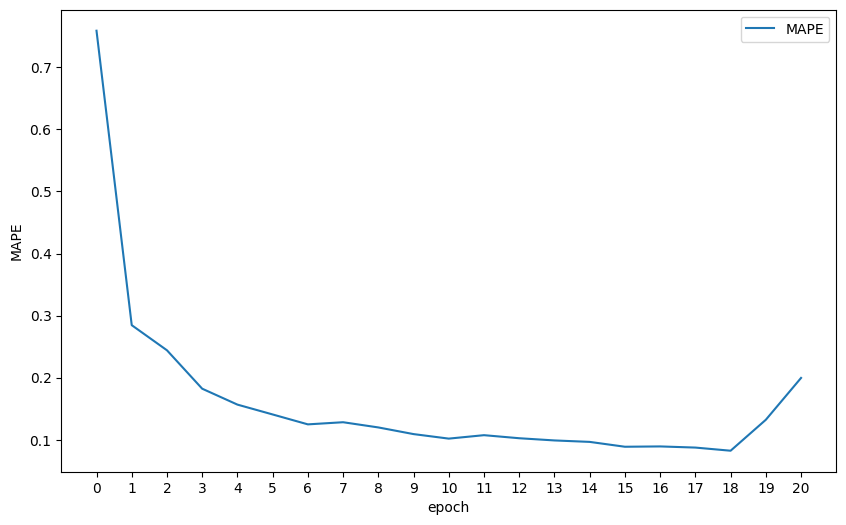

In [73]:
# 학습 중 MAPE 추이 확인

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))
plt.plot(train_hist[:21], label = 'MAPE')
plt.xlabel('epoch')
plt.xticks([i for i in range(0, 21)])
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [122]:
# 예측 테스트
with torch.no_grad():
    model.reset_hidden_state()
    pred = model(torch.unsqueeze(X_test_tensor, 0)).to('cpu') 

    # INVERSE
    pred_inverse = ss_2.inverse_transform(np.array(pred))
    testY_inverse = ss_2.inverse_transform(y_test_tensor.reshape(1, -1).to('cpu'))

def MAPE(true, pred, step_length):
    return round(np.mean(np.abs((testY_inverse-pred_inverse)/testY_inverse)), 3)

print('MAPE SCORE : {}%'.format(round(MAPE(testY_inverse, pred_inverse, step_length)*100, 6)))

MAPE SCORE : 1.1%


In [123]:
# 값 비교
import datetime

comparison = [[pred, true]for pred, true in zip(list(pred_inverse[0]), list(testY_inverse[0]))]
standard_time= pd.to_datetime('2023-03-20 18:00')
for idx, item in enumerate(comparison):
  print('{}의 실제 전력 수요는 {:,}이며, 예측값은 {:,}입니다. 백분율 오차는 {}%입니다.'.format(str(standard_time + datetime.timedelta(minutes=idx*5)), round(item[0]), round(item[1]), np.round(np.abs(item[0] - item[1])/item[1], 6) * 100))

2023-03-20 18:00:00의 실제 전력 수요는 68,776이며, 예측값은 68,472입니다. 백분율 오차는 0.4436%입니다.
2023-03-20 18:05:00의 실제 전력 수요는 68,863이며, 예측값은 68,745입니다. 백분율 오차는 0.1724%입니다.
2023-03-20 18:10:00의 실제 전력 수요는 69,329이며, 예측값은 68,754입니다. 백분율 오차는 0.8356%입니다.
2023-03-20 18:15:00의 실제 전력 수요는 69,236이며, 예측값은 68,968입니다. 백분율 오차는 0.3886%입니다.
2023-03-20 18:20:00의 실제 전력 수요는 68,643이며, 예측값은 68,864입니다. 백분율 오차는 0.3205%입니다.
2023-03-20 18:25:00의 실제 전력 수요는 68,872이며, 예측값은 68,967입니다. 백분율 오차는 0.1369%입니다.
2023-03-20 18:30:00의 실제 전력 수요는 69,556이며, 예측값은 69,443입니다. 백분율 오차는 0.1633%입니다.
2023-03-20 18:35:00의 실제 전력 수요는 69,072이며, 예측값은 69,546입니다. 백분율 오차는 0.6819000000000001%입니다.
2023-03-20 18:40:00의 실제 전력 수요는 69,171이며, 예측값은 69,743입니다. 백분율 오차는 0.8201%입니다.
2023-03-20 18:45:00의 실제 전력 수요는 68,884이며, 예측값은 69,668입니다. 백분율 오차는 1.1255%입니다.
2023-03-20 18:50:00의 실제 전력 수요는 68,938이며, 예측값은 69,877입니다. 백분율 오차는 1.3438%입니다.
2023-03-20 18:55:00의 실제 전력 수요는 68,976이며, 예측값은 69,971입니다. 백분율 오차는 1.4217%입니다.
2023-03-20 19:00:00의 실제 전력 수요는 69,069이며, 예측값은 69,993입니다. 백분율 오차는